# LAB 5 - Визуализация

Был использован самостоятельно полученный с помощью веб-парсинга датасет с сайта avito.ru

Данные актуальны на конец января 2022 года

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, r2_score as R2
from sklearn.model_selection import cross_val_score as cvs
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
dataset = pd.read_csv('avito_flats.csv')
dataset.head(7)

,title,price,address,area,rooms,floors,house_type,construction_date,ceiling_height,link
0,"1-к. квартира, 42,3 м кв., 25/25 эт.",4018500.0,"ул. Кустовая, д. 2А",42.3,1,25 из 25,монолитный,1 кв. 2023 года,NaN,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
1,"3-к. квартира, 44 м кв., 8/20 эт.",3873760.0,"ул. Краснополянская, д. 34",44.0,3,8 из 20,монолитный,3 кв. 2022 года,2.6,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
2,"Квартира-студия, 23,8 м кв., 3/25 эт.",2320000.0,"ул. Солдатова, д. 30Б",23.8,студия,3 из 25,монолитный,4 кв. 2023 года,2.6,https://www.avito.ru/perm/kvartiry/kvartira-st...
3,"1-к. квартира, 46,9 м кв., 6/6 эт.",6097000.0,"ул. Екатерининская, д. 10",46.9,1,6 из 6,монолитный,2 кв. 2024 года,NaN,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
4,"2-к. квартира, 79,3 м кв., 2/4 эт.",6937875.0,"ул. Борцов Революции, д. 1, корп. А, стр. 1",79.3,2,2 из 4,монолитный,4 кв. 2022 года,NaN,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
5,"2-к. квартира, 57,8 м кв., 10/25 эт.",5294480.0,"ул. Барамзиной, д. 38",57.8,2,10 из 25,монолитный,4 кв. 2022 года,2.7,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
6,"Квартира-студия, 30,4 м кв., 5/11 эт.",2552760.0,"ул. Ласьвинская, д. 15",30.4,студия,5 из 11,кирпичный,1 кв. 2024 года,2.7,https://www.avito.ru/perm/kvartiry/kvartira-st...


In [3]:
def all_data_tranforms(df, ff=False, tar_norm=False, stand_sc=False):
    df = df.copy()
    
    # DROP
    df.drop(['title', 'link', 'address', 'ceiling_height', 'construction_date'], axis=1, inplace=True)
    df.dropna(how='all', inplace=True)

    # lat, long
    # эти данные были получены с помощью сервиса nominatim
    # из колонки "address"
    coor_df = pd.read_csv('coor_avito_flats2.csv')
    df['lat'] = coor_df.lat
    df['lng'] = coor_df.lng
    
    # floors etc
    fract_floors = []
    building_flrs = []
    for i in df.floors:
        try:
            l = i.replace(' из ', ',').split(',')
            fract_floors.append(int(l[0])/int(l[1]))
            building_flrs.append(int(l[1]))
        except AttributeError:
            fract_floors.append(i)
            building_flrs.append(i)
    if ff:
        df['fract_flrs'] = fract_floors
    df['building_flrs'] = building_flrs
    df.drop(['floors'], axis=1, inplace=True)
    
    # rooms
    df.loc[df.rooms == 'студия', ['rooms']] = 0
    df.rooms = df.rooms.astype('int')
    
    # house_type
    ht = pd.get_dummies(df.house_type, prefix='type')
    df = df.join(ht)
    df.drop(['house_type'], axis=1, inplace=True)
    
    # drop nans in lat, lng
    df.dropna(axis=0, inplace=True)
    
    # price = target
    if tar_norm:
        target = np.log(df.price)
    else:
        target = df.price
    df.drop(['price'], axis=1, inplace=True)
    
    if stand_sc:
        scaler = StandardScaler().fit(df)
        df = pd.DataFrame(scaler.transform(df))
            
    return df, target

In [119]:
dataset = pd.read_csv('avito_flats.csv')
df, target = all_data_tranforms(dataset)

Итоговый набор данных для обучения

In [120]:
df.head(10)

,area,rooms,lat,lng,building_flrs,type_блочный,type_кирпичный,type_монолитный,type_панельный
0,42.3,1,57.969058,56.270723,25,False,False,True,False
1,44.0,3,57.967930,56.271902,20,False,False,True,False
2,23.8,0,57.971481,56.231502,25,False,False,True,False
3,46.9,1,58.012552,56.252127,6,False,False,True,False
4,79.3,2,58.027277,56.193065,4,False,False,True,False
5,57.8,2,57.999238,56.189330,25,False,False,True,False
6,30.4,0,58.004048,55.940203,11,False,True,False,False
7,81.3,3,57.975757,56.205954,9,False,True,False,False
8,44.0,3,57.967930,56.271902,20,False,False,True,False
9,59.1,0,57.971481,56.231502,25,False,False,True,False


## Объяснение как была получена эта итоговая таблица:

### Координаты

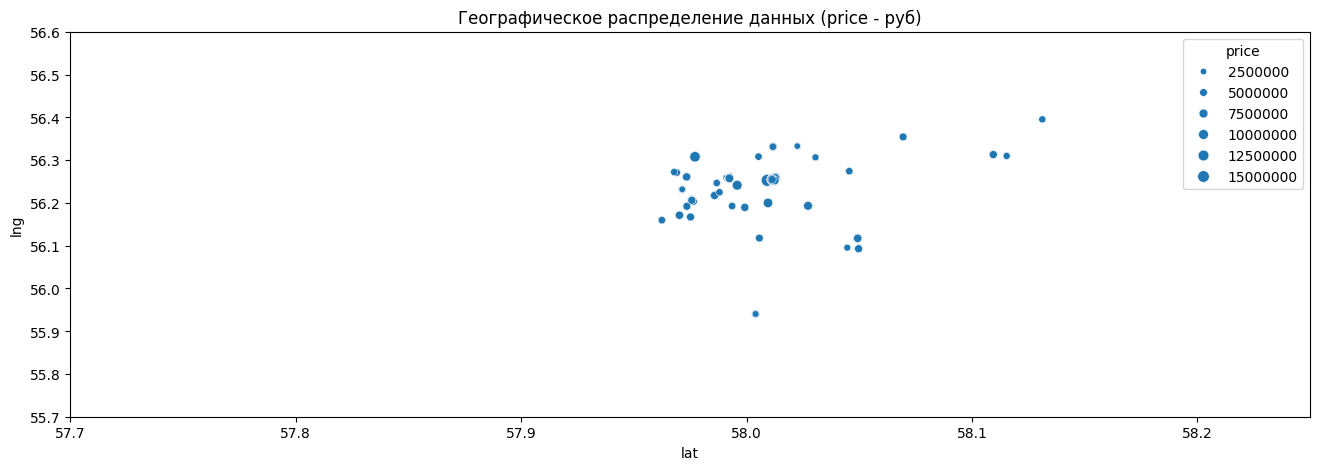

In [6]:
plt.figure(figsize=(16,5))
sns.scatterplot(
    data=df,
    x='lat',
    y='lng',
    size=target
)
plt.xlim([57.7,58.25])
plt.ylim([55.7,56.6])
plt.title("Географическое распределение данных (price - руб)")
plt.show()

Координаты это очень условный признак в данном случае. Почему?

Координаты были получены скриптом в сторонний файл, через который они подружаются во фрейм в функции all_data_transform. Скрипт работал на основе геокодинга (получение широты и долготы) по текстовому адресу с помощью бесплатного сервиса Nominatim, который в свою очередь не отличается лучшим качеством. При геокодинге полного адреса (г.Пермь + название улицы + номер дома) было обнаружено, что примерно 1/3 геопозиций находятся вообще не в Перми. Когда же поиск осуществлялся без указания номера дома (г.Пермь + название улицы), то почти все позиции находились в пределах города, как и должно быть. Но в таком случае многие квартиры разных цен имеют одну и ту же координату, тк находятся на одной улице, но в разных домах


### Цена (target)

Логарифмическое нормирование целевого признака

<Axes: >

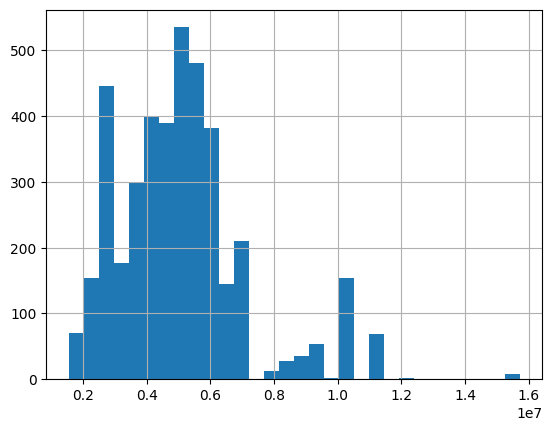

In [7]:
dataset.price.hist(bins=30)

<Axes: >

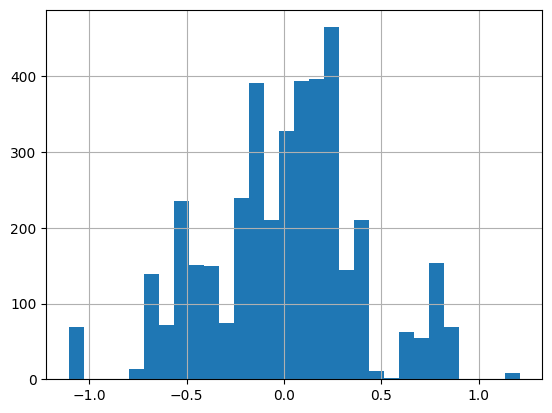

In [9]:
dataset['log_price'] = np.log(dataset.price)
dataset['log_price'] = dataset['log_price'] - dataset['log_price'].mean()
dataset.log_price.hist(bins=30)

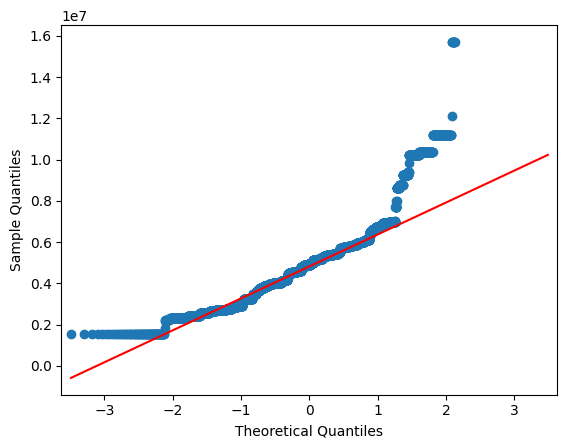

In [10]:
sm.qqplot(dataset.price, line='q');

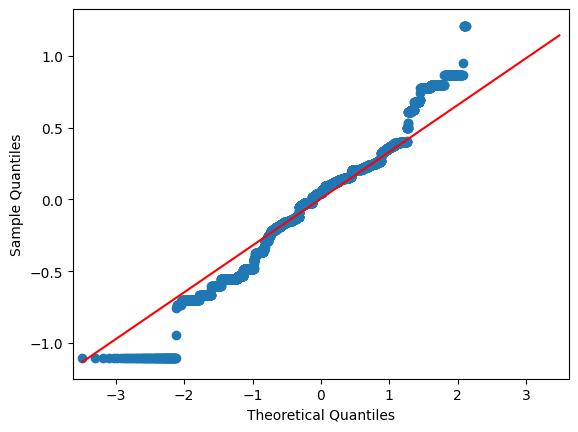

In [11]:
sm.qqplot(dataset.log_price, line='q');

Как видно, после логарифмирования целевого показателя его распределение становится более приближенным к нормальному. Но это лишь отчасти так. Благодаря графику квантилей видно, как после логарифмирования правый хвост распределение становится более нормального вида (точки верхней половины больше прижимаются к линии соответствия квантилей), но хвост слева от нуля на оборот вибивается. Даже если кажется это существенным, то на практике это почти никак не сказывалось, а в некоторых попытках предсказания моделей (, обучающихся на таргете без нормирования) были менее завышены.

### Тип дома

In [12]:
dataset.house_type.value_counts()

house_type
монолитный    2694
кирпичный      991
панельный      358
блочный          1
Name: count, dtype: int64

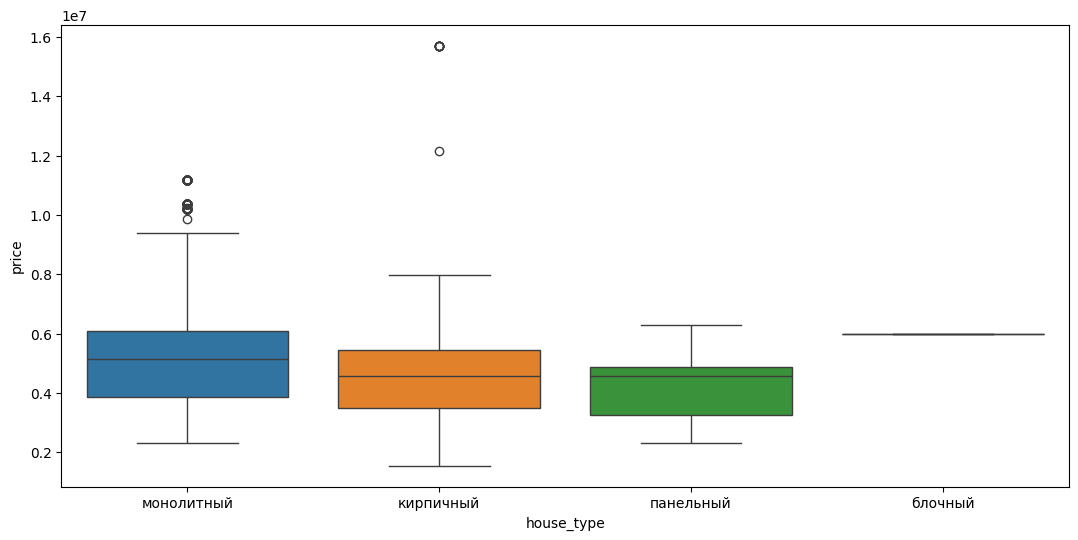

In [13]:
plt.figure(figsize=(13, 6))
sns.boxplot(
    x=dataset.house_type,
    y=dataset.price,
    hue=dataset.house_type,
    legend=False
)
plt.show()

Этот признак раобъем на бинарные подпризнаки при помощи `pandas.get_dummies()`:
```python
    pd.get_dummies(df.house_type, prefix='type')
``` 

### Высота потолков

In [14]:
dataset.ceiling_height.describe()

count    2178.000000
mean        2.748255
std         0.849718
min         2.000000
25%         2.700000
50%         2.700000
75%         2.700000
max        42.000000
Name: ceiling_height, dtype: float64

Здесь показано, что существует некая квартира с высотой потолка в 42м!

Посмотрим на нее

In [15]:
dataset.loc[dataset.ceiling_height == 42]

,title,price,address,area,rooms,floors,house_type,construction_date,ceiling_height,link,log_price
3338,"3-к. квартира, 58,9 м кв., 2/5 эт.",3800000.0,"Пермский край, Пермь, Вижайская ул., 23",58.9,3,2 из 5,кирпичный,1972,42.0,https://www.avito.ru/perm/kvartiry/3-k._kvarti...,-0.208912


Очевидно, что это выброс. Трудно представить квартиру высотой 42 метра на втором этаже в пятиэтажном доме

In [16]:
print("пустые значения / всего значений")
print(sum(dataset.ceiling_height.isnull()), "/", dataset.ceiling_height.shape[0])

пустые значения / всего значений
1934 / 4112


Признак можно удалить и не использовать совсем, посколько он не особо вариативный (у большинтсва квартир потолок 2.7м) да и почти у половины сэмплов отсутствуют значения 

### 2 фичи из признака `dataset.floors`

1 - дробь, которая показывает насколько высоко в доме находится квартира (1 - последний этаж, близко к 0 - на первых этажах)

2 - сколько всего этажей в доме

```python
fract_floors = []
    building_flrs = []
    for i in df.floors:
        try:
            l = i.replace(' из ', ',').split(',')
            fract_floors.append(int(l[0])/int(l[1]))
            building_flrs.append(int(l[1]))
        except AttributeError:
            fract_floors.append(i)
            building_flrs.append(i)
    if ff:
        df['fract_flrs'] = fract_floors
    df['building_flrs'] = building_flrs
    df.drop(['floors'], axis=1, inplace=True)
```

### Чистка

После всех вышеперечисленных преобразований и чисток `Nan`'ы останутся только в координатах и их будет менее 220 штук. Эти семплы просто удалим:
```python
    df.dropna(axis=0, inplace=True)
```

# LAB 6 - Классификация, кластеризация

In [62]:
def all_data_transforms_clf(df, ff=False, tar_norm=False, stand_sc=False):
    df = df.copy()
    
    # DROP
    df.drop(['title', 'link', 'address', 'ceiling_height', 'construction_date'], axis=1, inplace=True)
    df.dropna(how='all', inplace=True)

    # lat, long
    # эти данные были получены с помощью сервиса nominatim
    # из колонки "address"
    coor_df = pd.read_csv('coor_avito_flats2.csv')
    df['lat'] = coor_df.lat
    df['lng'] = coor_df.lng
    
    # floors etc
    fract_floors = []
    building_flrs = []
    for i in df.floors:
        try:
            l = i.replace(' из ', ',').split(',')
            fract_floors.append(int(l[0])/int(l[1]))
            building_flrs.append(int(l[1]))
        except AttributeError:
            fract_floors.append(i)
            building_flrs.append(i)
    if ff:
        df['fract_flrs'] = fract_floors
    df['building_flrs'] = building_flrs
    df.drop(['floors'], axis=1, inplace=True)
    
    # rooms
    df.loc[df.rooms == 'студия', ['rooms']] = 0
    df.rooms = df.rooms.astype('int')
    
    # house_type
    ht = pd.get_dummies(df.house_type, prefix='type')
    df = df.join(ht)
    df.drop(['house_type'], axis=1, inplace=True)
    
    # drop nans in lat, lng
    df.dropna(axis=0, inplace=True)
    
    # target = монолитный / не монолитный
    target = df["type_монолитный"].astype(np.int8)
    df.drop(["type_монолитный"], axis=1, inplace=True)
    
    if stand_sc:
        scaler = StandardScaler().fit(df)
        df = pd.DataFrame(scaler.transform(df))
            
    return df, target

In [64]:
df, target = all_data_transforms_clf(pd.read_csv("avito_flats.csv"))

In [65]:
target.sum() / len(target) # из всего датасета 65% это квартиры в монолитных домах

0.651356993736952

In [67]:
train_data, test_data, train_target, test_target = train_test_split(
    df, target, test_size=0.2, random_state=2
)

## Классификация

### Simple Decision Tree

In [71]:
simple_tree = DecisionTreeClassifier().fit(train_data, train_target)

print("Train accuracy:", accuracy_score(simple_tree.predict(train_data), train_target))
print("Valid accuracy:", accuracy_score(simple_tree.predict(test_data), test_target))
print(classification_report(simple_tree.predict(test_data), test_target))

Train accuracy: 1.0
Valid accuracy: 0.9986962190352021
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       264
           1       1.00      1.00      1.00       503

    accuracy                           1.00       767
   macro avg       1.00      1.00      1.00       767
weighted avg       1.00      1.00      1.00       767



### Logistic Regression

In [73]:
logit = LogisticRegression().fit(train_data, train_target)

print("Train accuracy:", accuracy_score(logit.predict(train_data), train_target))
print("Valid accuracy:", accuracy_score(logit.predict(test_data), test_target))
print(classification_report(logit.predict(test_data), test_target))

Train accuracy: 0.6505709624796084
Valid accuracy: 0.6544980443285529
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.65      0.79       767

    accuracy                           0.65       767
   macro avg       0.50      0.33      0.40       767
weighted avg       1.00      0.65      0.79       767



### Visualization

In [74]:
copy_df, copy_target = df.copy(), target.copy()

In [87]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(copy_df)

total_var = pca.explained_variance_ratio_.sum() * 100

plt.figure(figsize=(13,13))
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=copy_target,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_continuous_scale=["red", "green"]
)
fig.show()

<Figure size 1300x1300 with 0 Axes>

![](viz1.png)

In [84]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(copy_df)

fig = px.scatter(components,
    x=0, y=1,
    color=copy_target,
    color_continuous_scale=["red", "green"]
)

fig.show()

Теперь более наглядно можно увидеть почему логистическая регрессия показала себя хуже нежели обычное дерево решений - логистическая регрессия разграничивает классы линейной гиперплоскотью, а здесь видно, что точки находятся примерно в одном облаке, которое трудно разделить одной линией

## Кластеризация

In [88]:
from sklearn.cluster import KMeans, DBSCAN

In [95]:
kmeans = KMeans(n_clusters=2).fit(copy_df)

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=kmeans.labels_,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_continuous_scale=["purple", "blue"]
)
fig.show()

![](cluster1.png)

In [105]:
blue_part = components[np.where(kmeans.labels_ == 1), :][0]
purple_part = components[np.where(kmeans.labels_ == 0), :][0]

In [112]:
dbscan = DBSCAN(min_samples=30).fit(blue_part)

fig = px.scatter_3d(
    blue_part, x=0, y=1, z=2, color=dbscan.labels_,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_continuous_scale=["orange", "black"]
)
fig.show()

`min_samples=30`

![](dbscan30.png)

`min_samples=90`

![](dbscan90.png)

# LAB 7 - Регрессия

In [31]:
dataset = pd.read_csv('avito_flats.csv')
df, target = all_data_tranforms(dataset, tar_norm=False)

In [32]:
train_data, test_data, train_target, test_target = train_test_split(
    df, target, test_size=0.2, random_state=2
)

## Множественная линейная регрессия

In [34]:
lin = LinearRegression().fit(train_data, train_target)

np.mean(cvs(lin, test_data, test_target))

0.7461165604542334

In [35]:
mae(y_true=test_target, y_pred=lin.predict(test_data))

679689.2593630453

In [36]:
R2(y_true=test_target, y_pred=lin.predict(test_data))

0.7558625701942473

Средняя абсолютная ошибка говорит о том, что в среднем модель ошибается на 679 тыс. рублей

## Простой градиентный бустинг
(*вместо простой линейной регрессии*)

In [37]:
gbm = GradientBoostingRegressor(n_estimators=200, random_state=2).fit(train_data, train_target)

print(np.mean(cvs(gbm, test_data, test_target)))
print(cvs(gbm, test_data, test_target, cv=6))

0.9877044506222479
[0.97604453 0.93817859 0.9890259  0.99726121 0.98935546 0.99761374]


In [38]:
mae(y_true=test_target, y_pred=gbm.predict(test_data))

40788.49351709951

In [39]:
R2(y_true=test_target, y_pred=gbm.predict(test_data))

0.9873319339980682

           Feature  Importance
0             area    0.751855
1            rooms    0.002634
2              lat    0.164631
3              lng    0.049693
4    building_flrs    0.019263
5     type_блочный    0.000000
6   type_кирпичный    0.008525
7  type_монолитный    0.001136
8   type_панельный    0.002262


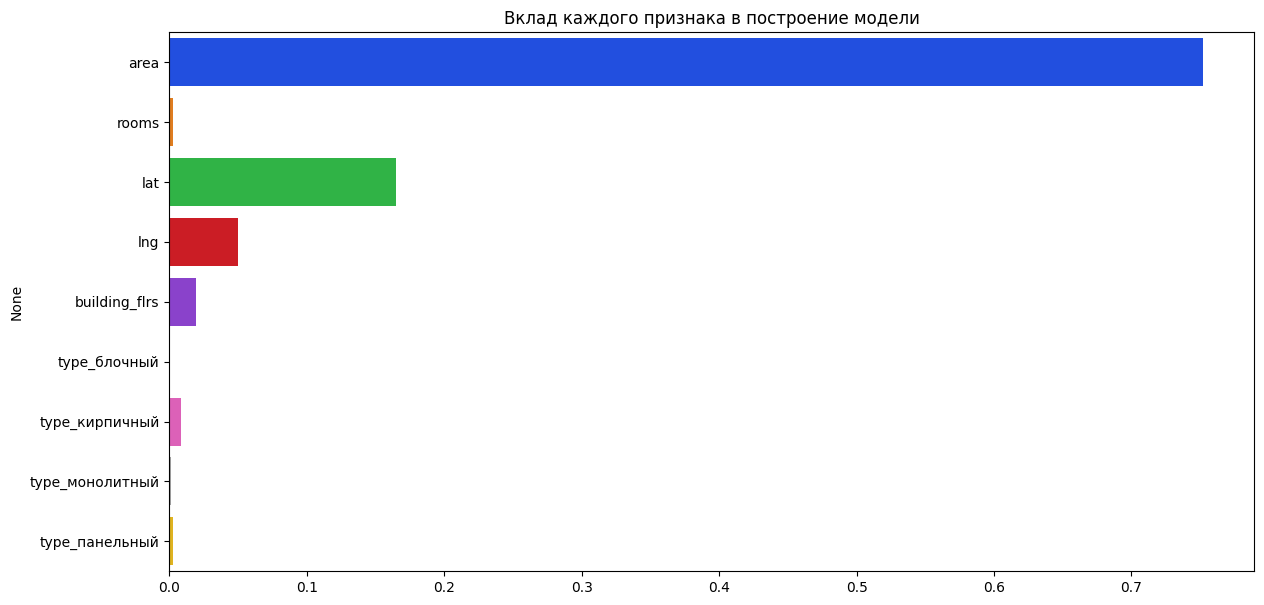

In [40]:
feat_imp = pd.DataFrame(data={'Feature': df.columns,
                              'Importance': gbm.feature_importances_})
print(feat_imp)

plt.figure(figsize=(14,7))
plt.title('Вклад каждого признака в построение модели')
sns.barplot(y=df.columns, x=gbm.feature_importances_, palette=sns.color_palette('bright', as_cmap=True))
plt.show()

# LAB 8

In [136]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input

In [146]:
def create_nn():
    input = Input(shape=(9,))
    x = Dense(8)(input)
    x = Dense(16)(x)
    x = Dense(1)(x)

    model = Model(inputs=input, outputs=x)
    model.compile(
        loss='mean_absolute_error',
        optimizer=keras.optimizers.Adam(0.001))
    return model


model = create_nn()

In [147]:
dataset = pd.read_csv('avito_flats.csv')
df, target = all_data_tranforms(dataset, tar_norm=False)

# bool => int
df["type_блочный"] = df["type_блочный"].astype(np.int8)
df["type_кирпичный"] = df["type_кирпичный"].astype(np.int8)
df["type_монолитный"] = df["type_монолитный"].astype(np.int8)
df["type_панельный"] = df["type_панельный"].astype(np.int8)

train_data, test_data, train_target, test_target = train_test_split(
    df, target, test_size=0.2, random_state=2
)

history = model.fit(train_data, train_target, validation_data=(test_data, test_target), epochs=500)

Epoch 1/500
96/96 [==============================] - 1s 4ms/step - loss: 4958779.5000 - val_loss: 4808905.0000
Epoch 2/500
96/96 [==============================] - 0s 2ms/step - loss: 4958251.0000 - val_loss: 4807921.5000
Epoch 3/500
96/96 [==============================] - 0s 2ms/step - loss: 4956425.5000 - val_loss: 4805040.0000
Epoch 4/500
96/96 [==============================] - 0s 2ms/step - loss: 4952080.0000 - val_loss: 4799056.0000
Epoch 5/500
96/96 [==============================] - 0s 2ms/step - loss: 4944107.0000 - val_loss: 4788963.0000
Epoch 6/500
96/96 [==============================] - 0s 2ms/step - loss: 4931558.5000 - val_loss: 4773886.0000
Epoch 7/500
96/96 [==============================] - 0s 2ms/step - loss: 4913591.5000 - val_loss: 4753028.0000
Epoch 8/500
96/96 [==============================] - 0s 2ms/step - loss: 4889471.0000 - val_loss: 4725698.0000
Epoch 9/500
96/96 [==============================] - 0s 2ms/step - loss: 4858531.0000 - val_loss: 4691263.5000
E

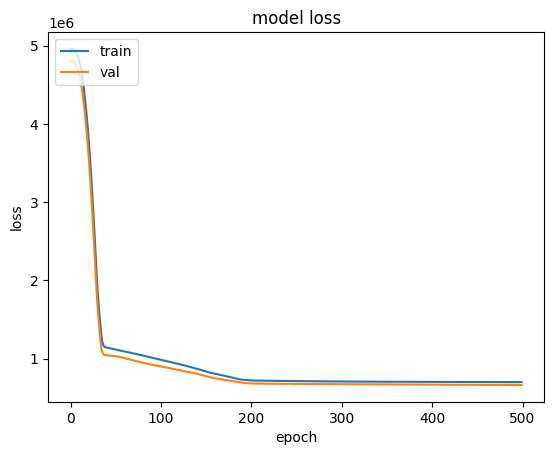

In [148]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()